# Classifying Google's Quickdraw Drawings 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
SIZE = 28
LABELS = 5
CHANNELS = 1
BREAKS = 100

---
## Visualizer Functions
These are some helper functions

In [3]:
def show(tensor, labels):
    fig, ax = plt.subplots(3, 10, figsize = (16, 6))
    for i in range(3):
        for j in range(10):
            x = np.random.randint(0, len(tensor))
            ax[i,j].matshow(tensor.reshape(-1, SIZE, SIZE)[x], cmap=cm.gray_r)
            ax[i,j].set_title("{}".format(labels[x]))
            ax[i,j].axis('off')
    plt.show()

In [4]:
def plotter(history):
    at, av, lt, lv = zip(*history)
    fig = plt.figure(figsize=(15, 8)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

    ax1.plot(np.arange(0, len(at), 1), at,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(at[-1]))
    ax1.plot(np.arange(0, len(av), 1), av,".-", color='#FFA933', label="Validation: {0:.2f}%".format(av[-1]))
    ax1.grid(True); ax1.legend(loc="lower right"); ax1.set_title("Accuracy per epoch")

    ax2.plot(np.arange(0, len(lt), 1), lt,".-", color='#2A6EA6', label="Training: {0:.2f}".format(lt[-1]))
    ax2.plot(np.arange(0, len(lv), 1), lv,".-", color='#FFA933', label="Validation: {0:.2f}".format(lv[-1]))
    ax2.grid(True); ax2.legend(loc="upper right"); ax2.set_title("Cost per epoch")
    plt.show()

---
## Data Import

In [5]:
datapath = "/Users/desiredewaele/Google Drive/Datasets/Quickdraw/"
files = np.array([f for f in os.listdir(datapath) if f.endswith('.npy')])

tensor = np.empty((0, 784))
labels = np.empty(0)
for i, file in enumerate(files):
    data = np.load(datapath+file)[:10000]
    category = np.repeat(file[:-4], data.shape[0])
    tensor = np.append(tensor, data, axis=0)
    labels = np.append(labels, category, axis=0)

In [6]:
pd.DataFrame(tensor).head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print(labels)

['airplane' 'airplane' 'airplane' ..., 'piano' 'piano' 'piano']


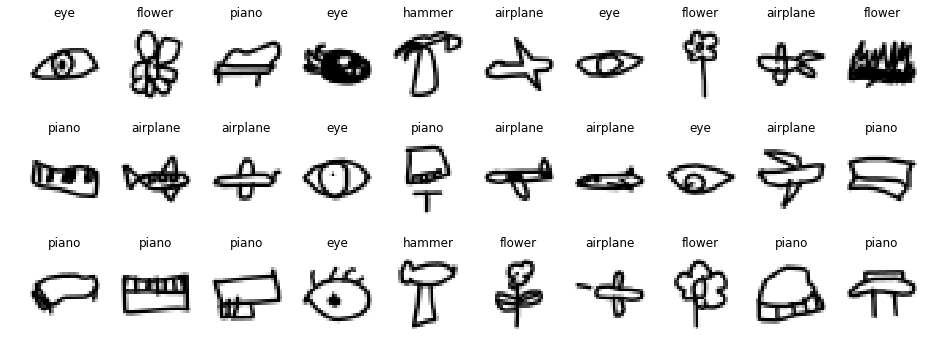

In [8]:
show(tensor, labels)

---
## Data Preproccessing

In [9]:
print('Data set: {} '.format(tensor.shape, labels.shape))

Data set: (50000, 784) 


In [10]:
tensor = tensor.reshape(-1, SIZE, SIZE, CHANNELS)
target = pd.get_dummies(pd.DataFrame(labels)).values

In [11]:
print('Data set: {} '.format(tensor.shape, target.shape))

Data set: (50000, 28, 28, 1) 


In [12]:
from sklearn.model_selection import train_test_split
traindevX, testX, traindevY, testY = train_test_split(tensor, target, test_size=10000, random_state=100)
trainX, validX, trainY, validY = train_test_split(traindevX, traindevY, test_size=10000, random_state=100)

In [13]:
print('Training set:   {} {}'.format(trainX.shape, trainY.shape))
print('Validation set: {} {}'.format(validX.shape, validY.shape))
print('Testing set:    {} {}'.format(testX.shape, testY.shape))

Training set:   (30000, 28, 28, 1) (30000, 5)
Validation set: (10000, 28, 28, 1) (10000, 5)
Testing set:    (10000, 28, 28, 1) (10000, 5)


---
## Convolutional Neural Network

In [14]:
BATCH = 20
FILTER = 5
NUMFILTERS = 32
HIDDEN = 100
RATE = 1e-4
STEPS = 5

In [15]:
graph = tf.Graph()
with graph.as_default():

    with tf.name_scope('Input'):
        tfDataX = tf.placeholder(tf.float32, (None, SIZE, SIZE, CHANNELS), 'Tensor')
        tfDataY = tf.placeholder(tf.float32, (None, LABELS), 'Target')
        tfDrop = tf.placeholder(tf.float32, None, 'Dropout')

    with tf.name_scope('Variables'):
        w1 = tf.get_variable('W1', [FILTER, FILTER, CHANNELS, NUMFILTERS], 
                             initializer=tf.contrib.layers.xavier_initializer())
        w2 = tf.get_variable('W2', [FILTER, FILTER, NUMFILTERS, NUMFILTERS*2], 
                             initializer=tf.contrib.layers.xavier_initializer())
        w3 = tf.get_variable('W3', [SIZE//4 * SIZE//4 * NUMFILTERS*2, HIDDEN], 
                             initializer=tf.contrib.layers.xavier_initializer())
        w4 = tf.get_variable('W4', [HIDDEN, LABELS],
                             initializer=tf.contrib.layers.xavier_initializer())

    with tf.name_scope('ConvolutionalNetwork'):
        def model(x):
            # Convolutional layer 1
            x = tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='SAME')
            x = tf.nn.relu(x)
            x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

            # Convolutional layer 2
            x = tf.nn.conv2d(x, w2, strides=[1, 1, 1, 1], padding='SAME')
            x = tf.nn.relu(x)
            x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

            # Fully connected layer
            x = tf.reshape(x, (-1, SIZE//4 * SIZE//4 * NUMFILTERS*2))
            x = tf.nn.relu(tf.matmul(x, w3))

            # Readout layer with dropout
            x = tf.nn.dropout(x, tfDrop)
            x = tf.matmul(x, w4)
            return x
  
    with tf.name_scope('Training'):
        logits = model(tfDataX)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY), name="Cost")
        optimizer = tf.train.AdamOptimizer(RATE).minimize(cost, name="Optimize")

    # Predictions and Accuracy.
    predictions = {"classes": tf.argmax(logits, 1), "probabilities": tf.nn.softmax(logits)}
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions['classes'], tf.argmax(tfDataY, 1)), "float"))
    
    with tf.name_scope('Summarize'):
        tf.summary.scalar("Cost", cost)
        summary = tf.summary.merge_all()

In [ ]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    writer = tf.summary.FileWriter('/Users/desiredewaele/TensorBoard/test', session.graph)
    history = []
    for step in range(STEPS):
        print('Step {} of {}.'.format(step+1, STEPS))
        for batchNr in range(len(trainX) // BATCH):
            print('.', end='')
            offset = BATCH * batchNr
            batchX = trainX[offset:offset+BATCH]
            batchY = trainY[offset:offset+BATCH]
            session.run(optimizer, {tfDataX: batchX, tfDataY: batchY, tfDrop: 0.5})
        lt, at = session.run([cost, accuracy], {tfDataX: batchX, tfDataY: batchY, tfDrop: 1.0})
        lv, av = session.run([cost, accuracy], {tfDataX: validX, tfDataY: validY, tfDrop: 1.0})
        history.append((at, av, lt, lv))
    predictions = session.run(predictions, {tfDataX: testX, tfDrop: 1.0})
    accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY, tfDrop: 1.0})
    print('\nTest accuracy: %.2f%%' % accuracy)

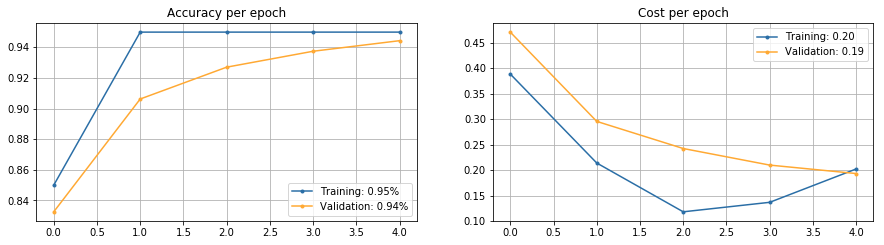

In [25]:
plotter(history)

In [26]:
print(predictions["classes"][0:3])
print(predictions["probabilities"][0:3])

[0 0 4]
[[  9.99999404e-01   5.16504084e-09   1.08729514e-09   1.82731327e-07
    3.45045777e-07]
 [  6.95389032e-01   3.26152965e-02   7.54933879e-02   1.84486136e-01
    1.20161269e-02]
 [  4.13188511e-11   1.00728741e-08   3.67890385e-10   1.56584923e-09
    1.00000000e+00]]


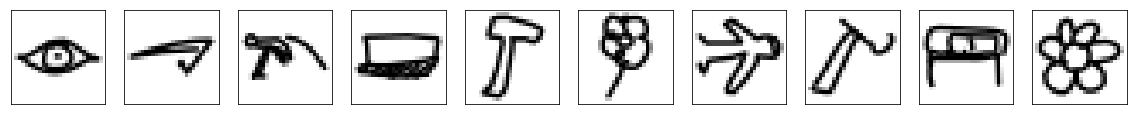

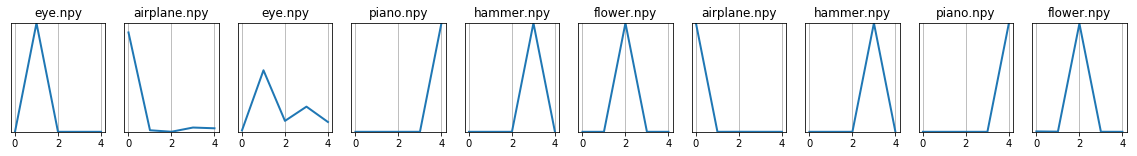

In [39]:
fig1, ax1 = plt.subplots(1, 10, figsize = (20, 2))
fig2, ax2 = plt.subplots(1, 10, figsize = (20, 2))

for t in range(10):
    x = np.random.randint(0, len(testX))
    ax1[t].matshow(testX[x,:,:,0], cmap=cm.gray_r)
    ax1[t].get_yaxis().set_visible(False); ax1[t].get_xaxis().set_visible(False)
    ax2[t].plot(predictions["probabilities"][x], lw=2)
    ax2[t].set_title("{}".format(files[predictions["classes"][x]]))
    ax2[t].get_yaxis().set_visible(False); ax2[t].set_ylim([0, 1]); ax2[t].grid(True)
plt.show()